# section6

## 本章での内容
- モデルの性能の偏りのない推定量の抽出
- 機械学習のアルゴリズムに共通する問題の診断
- 機械学習のモデルのチューニング
- 様々な性能指標に基ずく予測モデルの評価

## Pipelineによるワークフロウの効率化

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [5]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =     train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [10]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


### モデルの性能評価のためのデータ分割法

#### 1.ホールドアウト法

トレーニングデータセット（それぞれのモデルのパラメータチューニングに用いる）  
検証データセット（モデルの選択に用いる）  
テストデータセット（最終的な性能評価に用いる）  

### 2.k分割交差検証


バイアス、バリアンスのバランスが最も良いものは**k=10**であることが実験で示されている。  
小さなデータセットに対しては分割数を増やすとよいし、大きなデータセットに対しては分割数を小さくすることで計算コストを抑え正確になる。

１個抜きの交差検証はとても小さなデータに対して行われることがある。

層化ｋ分割交差検証は特にクラスの比率が均等ではないケースで評価のバイアスとバリアンスを改善することができる。各サブセットでのクラスの比率を全体の比率で維持する方法である。

In [46]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

khold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores =[]

for k, (train, test) in enumerate(khold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(k, np.bincount(y_train[train]), score)

0 [256 153] 0.9347826086956522
1 [256 153] 0.9347826086956522
2 [256 153] 0.9565217391304348
3 [256 153] 0.9565217391304348
4 [256 153] 0.9347826086956522
5 [257 153] 0.9555555555555556
6 [257 153] 0.9777777777777777
7 [257 153] 0.9333333333333333
8 [257 153] 0.9555555555555556
9 [257 153] 0.9555555555555556


In [47]:
print(np.mean(scores), np.std(scores))

0.9495169082125603 0.013854294239660376


In [58]:
%%time
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train, y=y_train,
                         cv=10, n_jobs=1)
print(scores)
print(np.mean(scores), np.std(scores))

[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
0.9495169082125603 0.013854294239660376
Wall time: 59.9 ms


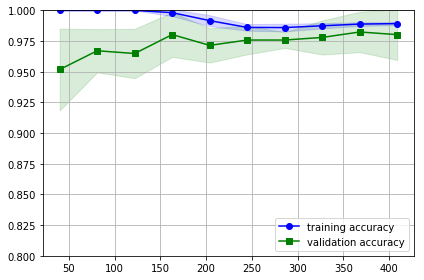

In [67]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15,
                 color='blue')


plt.plot(train_sizes, test_mean,
         color='green', marker='s',
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15,
                 color='green')

plt.grid()
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()

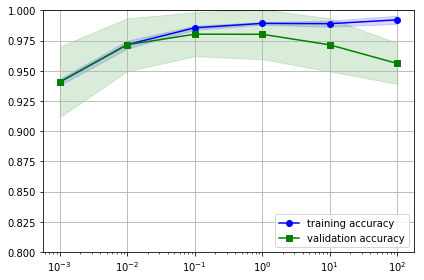

In [76]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         label='training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15,
                 color='blue')


plt.plot(param_range, test_mean,
         color='green', marker='s',
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15,
                 color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [80]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('test accuracy: %.3f' % clf.score(X_test, y_test))

test accuracy: 0.974


randomにサーチを行う、scikit-learnのRandomizedSearchCVクラスを使用することもできる

In [82]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(np.mean(scores), np.std(scores))

0.9736263736263737 0.014906219743132467


In [83]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs,
                         X_train,
                         y_train,
                         scoring='accuracy',
                         cv=5)
print(np.mean(scores), np.std(scores))

0.9340659340659341 0.015540808377726326


In [85]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


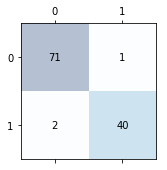

In [88]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')



In [89]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print(precision_score(y_true=y_test, y_pred=y_pred))
print(recall_score(y_true=y_test, y_pred=y_pred))
print(f1_score(y_true=y_test, y_pred=y_pred))

0.975609756097561
0.9523809523809523
0.963855421686747


In [94]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=1)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  cv=10,
                  scoring=scorer,
                  n_jobs=1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hiroyuki\Downloads\

0.978500666000666
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


C:\Users\hiroyuki\Downloads\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


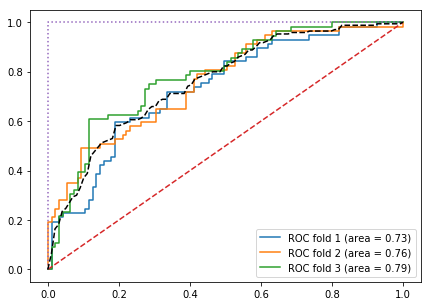

In [111]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', random_state=0, C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0,1],
         [0,1],
         linestyle='--')
plt.plot([0,0,1],
         [0,1,1],
         linestyle=':')
plt.legend(loc='lower right')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--')

In [115]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

In [116]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

## クラスが偏っているときの問題
- モデルの評価方法を見直す必要がある。（偽陰性を減らしたいのか偽陽性を減らしたいのか）
- モデルは学習する際に暗黙的にデータセットが大多数を占めるクラスに基づいて予測を最適化してしまう。
二つ目についての解決法は、少数派クラスに関する誤った予測に大きなペナルティを与えればよい。scikit-learnではパラメータにclass_weight='balanced'を設定するだけでそうしたペナルティを調整することができる。ほかの手法としては、少数派クラスのアップサンプリング、多数クラスのダウンサンプリング、人工的なトレーニングデータの生成などがあげられる。

#### 人工的なトレーニングサンプルの生成
SMOTEがよく使われる。imbalanced-learnというPythonライブラリを調べてみるとよい。